<a href="https://colab.research.google.com/github/kisung2577/CMPE-255/blob/main/AutoVIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xlrd --ignore-installed --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.4 MB/s 


In [ ]:
!pip install featurewiz --ignore-installed --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 15.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import itertools
import gc
import math
from typing import Tuple, List, Dict
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
import dateutil.easter as easter

In [ ]:
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 714 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
featurewiz 0.2.2 requires jupyter, which is not installed.
featurewiz 0.2.2 requires lightgbm>=3.2.1, but you have lightgbm 2.2.3 which is incompatible.
featurewiz 0.2.2 requires Pillow>=9.0.0, but you have pillow 7.1.2 which is incompatible.
featurewiz 0.2.2 requires pyarrow~=7.0.0, but you have pyarrow 6.0.1 which is incompatible.
featurewiz 0.2.2 requires xgboost>=1.5.1, but you have xgboost 0.90 which is incompatible.


In [ ]:
import featurewiz as FW
import xgboost

Imported 0.2.02 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [ ]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2022-10-28 07:31:33.902903


In [ ]:

# read data
in_kaggle = True

def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../content/train.csv'
        test_path = '../content/test.csv'
        sample_submission_path = '../content/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/train.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

original_train_df = pd.read_csv(train_set_path)
original_test_df = pd.read_csv(test_set_path)
subm = pd.read_csv(sample_subm_path)
print(original_train_df.shape, original_test_df.shape)

(26298, 6) (6570, 5)


In [ ]:
original_train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [ ]:
original_test_df.head()

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [ ]:
%%time
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [ ]:
%%time
# The dates are read as strings and must be converted
for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True, drop=False)

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 20.9 ms


In [ ]:
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    new_df = pd.DataFrame({'year': df.date.dt.year, # This feature makes it possible to fit an annual growth rate
                           'dayofyear': df.date.dt.dayofyear,
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                           'dec29': (df.date.dt.month == 12) & (df.date.dt.day == 29), # end-of-year peak
                           'dec30': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                          })

    # Easter
    new_df['easter_week'] = False
    for year in range(2015, 2020):
        easter_date = easter.easter(year)
        easter_diff = df.date - np.datetime64(easter_date)
        new_df['easter_week'] = new_df['easter_week'] | (easter_diff > np.timedelta64(0, "D")) & (easter_diff < np.timedelta64(8, "D"))
    
    # Growth is country-specific
    #for country in ['Finland', 'Norway', 'Sweden']:
    #    new_df[f"{country}_year"] = (df.country == country) * df.date.dt.year
        
    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Sticker']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 100): # 100
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'sticker_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Sticker']
        new_df[f'sticker_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Sticker']

    return new_df

train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)
test_df.year = 2018 # no growth patch, see https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298318

test_df['date'] = original_test_df.date
test_df['num_sold'] = 0 # An artificial step 

features = test_df.columns

for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float64)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
ALERT: nrows=26298. Hence featurewiz will randomly sample that many rows.
    Change nrows=None if you want all rows...
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Sampling 26298 rows from dataframe given
    Since dask_xgboost_flag is True, reducing memory size and loading into dask
    Loaded train data. Shape = (26298, 608)
    Some column names had special characters which were removed...
#### Single_Label Regression problem ####
loading the entire test dataframe - there is no nrows limit applicable ###

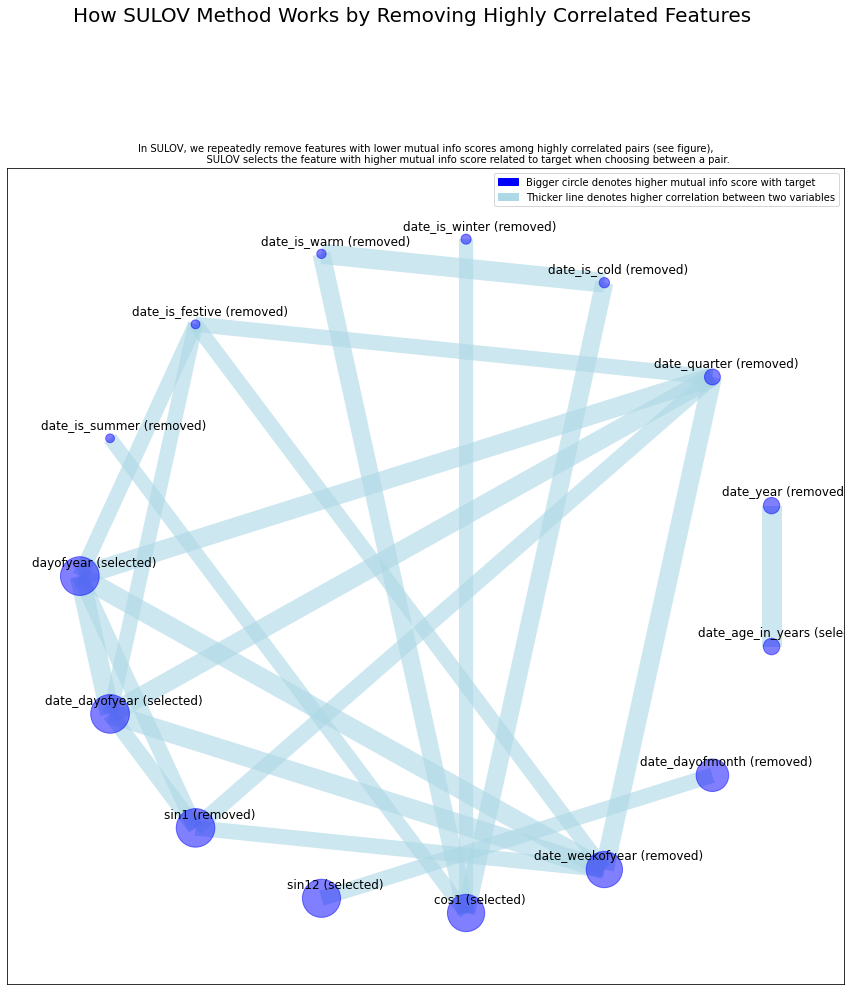

Time taken for SULOV method = 22 seconds
    Adding 16 categorical variables to reduced numeric variables  of 596
Finally 612 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (26298, 613)
    Shape of test data after adding missing values flags  = (6570, 612)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 612 
    Taking top 93 features per iteration...
    XGBoost version using 0.90 as tree method: gpu_hist
Number of booster rounds = 100
        using 612 variables...
Regular XGBoost is crashing due to: [07:

In [ ]:
%%time
target = 'num_sold'
train_best, test_best = FW.featurewiz(train_df, target, corr_limit=0.70, verbose=2, sep=',', 
        header=0, test_data=test_df,feature_engg='', category_encoders='', dask_xgboost_flag=True, nrows=train_df.shape[0])

In [ ]:
print(test_best.columns.tolist())

['cos10', 'cos11', 'cos12', 'cos13', 'cos14', 'cos15', 'cos16', 'cos17', 'cos18', 'cos19', 'cos2', 'cos20', 'cos21', 'cos22', 'cos23', 'cos24', 'cos25', 'cos26', 'cos27', 'cos28', 'cos29', 'cos3', 'cos30', 'cos31', 'cos32', 'cos33', 'cos34', 'cos35', 'cos36', 'cos37', 'cos38', 'cos39', 'cos4', 'cos40', 'cos41', 'cos42', 'cos43', 'cos44', 'cos45', 'cos46', 'cos47', 'cos48', 'cos49', 'cos5', 'cos50', 'cos51', 'cos52', 'cos53', 'cos54', 'cos55', 'cos56', 'cos57', 'cos58', 'cos59', 'cos6', 'cos60', 'cos61', 'cos62', 'cos63', 'cos64', 'cos65', 'cos66', 'cos67', 'cos68', 'cos69', 'cos7', 'cos70', 'cos71', 'cos72', 'cos73', 'cos74', 'cos75', 'cos76', 'cos77', 'cos78', 'cos79', 'cos8', 'cos80', 'cos81', 'cos82', 'cos83', 'cos84', 'cos85', 'cos86', 'cos87', 'cos88', 'cos89', 'cos9', 'cos90', 'cos91', 'cos92', 'cos93', 'cos94', 'cos95', 'cos96', 'cos97', 'cos98', 'cos99', 'mug_cos1', 'mug_cos10', 'mug_cos11', 'mug_cos12', 'mug_cos13', 'mug_cos14', 'mug_cos15', 'mug_cos16', 'mug_cos17', 'mug_cos1

In [ ]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2022-10-28 07:35:43.236985
Elapsed time:  0:04:09.334082
